In [1]:
import os
import glob
import pickle as pkl
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import r2_score, \
    explained_variance_score, normalized_mutual_info_score, mutual_info_score, make_scorer, mean_absolute_error
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin

from skll.metrics import spearman, pearson

from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance

from pylab import rcParams
rcParams['figure.figsize'] = 10,12

# Import the Data
Load the data from the pickle files created in `preproccess.ipynb`

In [2]:
with open("../pkl/data/data_outliers_removed", "rb" ) as f:
    [X, Y] = pkl.load(f)

## Modelling with XGB

### Setup

In [3]:
splitter= RepeatedKFold(n_splits=10,n_repeats=5)

In [4]:
scoring = {'r2':make_scorer(r2_score), 
           'SRC':make_scorer(spearman), 
           'PCC':make_scorer(pearson), 
           'MI':make_scorer(mutual_info_score), 
           'MAE':make_scorer(mean_absolute_error)}

In [5]:
try:
    overall_results = pd.read_csv('../reports/model_results.csv',index_col=0)
except FileNotFoundError:
    overall_results = pd.DataFrame(columns = scoring.keys())

### Regressor only

The search space below is the final step after some hand tuning, the code for which is not currently shown.

In [ ]:
param_grid = {'max_depth': [9], 'n_estimators': [50,100,150], 'colsample_bytree': [0.9]}
refit = 'r2'

search = GridSearchCV(estimator=XGBRegressor(),param_grid=param_grid,scoring=scoring,refit=refit,cv=splitter)
fitted = search.fit(X,Y)

In [ ]:
for score_name in scoring.keys():
    overall_results.loc['XGB Regressor',score_name] = np.round(np.mean(search.cv_results_['mean_test_'+score_name]),2)
overall_results

In [ ]:
model = fitted.best_estimator_
with open("../models/xgb_regressor.model", "wb" ) as f:
    pkl.dump(model,f)

### Classifier only

In [ ]:
Y_binary = (Y != 0)
Y_binary = Y_binary.astype(int)

In [ ]:
param_grid = {'max_depth': [7, 9, 11]}

search= GridSearchCV(estimator=XGBClassifier(),param_grid=param_grid,scoring=('accuracy','recall'),refit='accuracy',cv=splitter)
fitted = search.fit(X,Y_binary)

In [ ]:
search.best_score_

0.9667560321715818

### Combined classifier and regressor

Combine the XGBClassifier and XGBRegressor. XGBRegressor output is used when the classifier predicts nonzero, otherwise model prediction is 0.

In [7]:
from dairyml import XGBCombined

Evaluate combined model

In [8]:
model = XGBCombined(max_depth_reg=9,max_depth_clas=7)

In [ ]:
xgb_combined_results = cross_validate(model,X,Y,cv=splitter,scoring=scoring)

In [9]:
for score_name in scoring.keys():
    overall_results.loc['XGB Combined',score_name] = np.round(np.mean(xgb_combined_results['test_'+score_name]),2)
overall_results

,r2,SRC,PCC,MI,MAE
Dummy Mean,-0.02,0.00,-0.00,-0.00,1.94
Dummy Median All,-0.32,0.00,-0.00,-0.00,1.68
Dummy Median Nonzero,-0.08,0.00,-0.00,-0.00,1.77
"Perfect Clasif., Mean Regr.",0.13,0.73,0.41,0.53,1.53
Lasso,0.45,0.61,0.70,3.07,1.23
Bounded Lasso,0.55,0.64,0.75,2.87,1.08
Bounded Lasso + LogReg,0.64,0.80,0.82,2.66,0.86
FFNN (Regressor Only),0.77,0.78,0.88,3.07,0.66
XGB Regressor,0.80,0.85,0.90,3.06,0.47
XGB Combined,0.83,0.90,0.92,3.05,0.41


Save results to CSV

In [10]:
overall_results.to_csv('../reports/model_results.csv')

#### Plot actual vs predicted values

In [ ]:
splitter_non_repeat = KFold(n_splits=10,shuffle=True,random_state=7)
y_pred = cross_val_predict(model,X,Y,cv=splitter_non_repeat)

In [ ]:
fig, ax = plt.subplots(figsize=[8,8])
ax.scatter(Y, y_pred, alpha=0.5)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('XGB Combined Model \n Actual vs Predicted lactose')
plt.show()

### Plot feature importances

Fit the model to the full dataset

In [9]:
model = XGBCombined(max_depth_reg=9,max_depth_clas=7,importance_type='frequency')
model.fit(X,Y)

XGBCombined(importance_type='frequency', max_depth_clas=7, max_depth_reg=9)

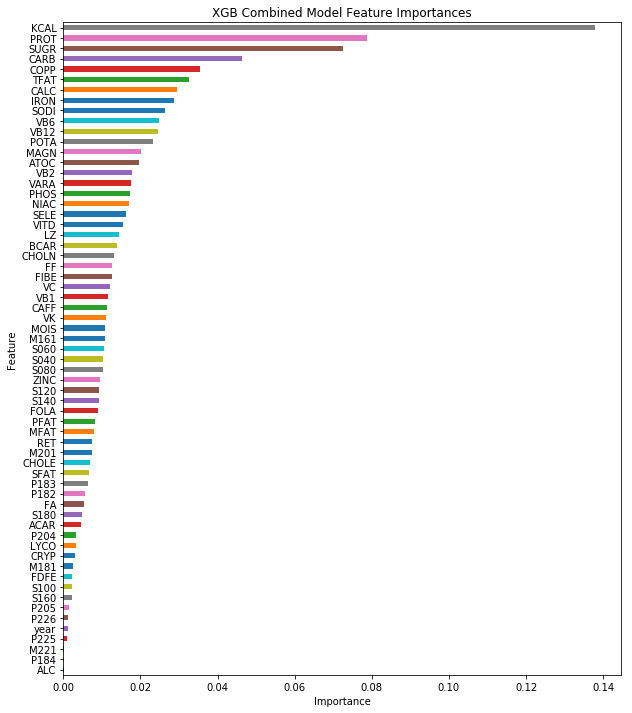

In [60]:
coefficients = pd.DataFrame()
coefficients['Feature'] = X.columns
coefficients['XGB Combined Importance'] = model.reg.feature_importances_
coefficients = coefficients.set_index('Feature')
axs = coefficients.sort_values('XGB Combined Importance').plot.barh(y='XGB Combined Importance')
axs.set_title('XGB Combined Model Feature Importances')
axs.set_xlabel('Importance')
axs.get_legend().remove()

In [47]:
coefficients.to_csv('../reports/feature_importances.csv')

#### Save model to file

In [14]:
with open("../models/xgb_combined.model", "wb" ) as f:
    pkl.dump(model,f)

In [10]:
with open("../models/xgb_combined.model", "rb" ) as f:
    model = pkl.load(f)